In [1]:
import torch
from utility import My_Dataset
from utility import mean_and_std,get_params_and_gradients_norm
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F 
from torch.utils.data import Dataset #
from torch.utils.data import DataLoader
import torchvision.datasets as datasets 
import torchvision.transforms as T
from torch.utils.tensorboard import SummaryWriter 
import numpy as np #
from skimage import io #
from matplotlib import pyplot as plt

/home/maria/.local/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [2]:
import os 
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd 

In [3]:
ARCH = [8,'M',16,'M',32,0]   #architecture of the base network 

In [4]:
class BASE_CNN(nn.Module): 
    def __init__(self,in_channels = 1, num_classes = 15, architecture = ARCH): 
        super(BASE_CNN,self).__init__()
        self.in_channels = in_channels 
        self.conv_layers = self.create_conv_layers(architecture)
        self.fcs = nn.Sequential(nn.Linear(32*12*12,num_classes))
    
    def create_conv_layers(self, architecture): 
        layers = [] 
        in_channels = self.in_channels 
        for x in architecture: 
            if(type(x)==int and x!=0): 
                out_channels = x 
                layers += [nn.Conv2d(in_channels=in_channels, out_channels = out_channels, kernel_size=(3,3),
                           stride =1, padding = (0,0)),nn.ReLU()]
                in_channels = x
            elif x =='M': 
                layers +=[nn.MaxPool2d(kernel_size= (2,2),stride = (2,2))]
        return nn.Sequential(*layers)
    def initialize_weight(self): 
        
        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                nn.init.normal_(m.weight, mean=0.0, std=0.01)
                if m.bias is not None: 
                    nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.Linear): 
                nn.init.normal_(m.weight, mean=0.0, std=0.01)
                nn.init.constant_(m.bias,0)
    def forward(self,x): 
        x = self.conv_layers(x)
        x = x.reshape(x.shape[0],-1)
        x = self.fcs(x)
        return x

In [5]:
mean, std = mean_and_std()

In [6]:
transforms = T.Compose([
    T.ToTensor(),
    T.Normalize([mean], [std]),
])


In [12]:
learning_rate = 0.01
batch_size = 32 

In [13]:
dataset = My_Dataset(root = "train", transform = transforms)

In [14]:
train_number = int(len(dataset)*0.85)
val_number = len(dataset)-train_number

In [15]:
train_set, val_set = torch.utils.data.random_split(dataset,[train_number,val_number]) 

In [16]:
train_loader = DataLoader(dataset = train_set, batch_size=batch_size, shuffle=True )
val_loader = DataLoader(dataset = val_set, batch_size=64, shuffle=False )

In [17]:
device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
device ="cpu"

In [21]:
model = BASE_CNN(1,15).to(device)
model.initialize_weight() 

In [22]:
optimizer = optim.SGD(model.parameters(),lr = learning_rate)
criterion = nn.CrossEntropyLoss() 

In [23]:
writer_1 = SummaryWriter(f'runs/MODEL_1')
trajectory_1 = {"parameters": [], "gradients": []}
step = 0

In [24]:
def train_model(model, num_epochs, train_loader, criterion, optimizer,writer,step = 0,trajectory=None, weights_check = False): 
   # global step = step
    for epoch in range(num_epochs): 
        step+=1
        losses = []
        accuracy =[]
        if(weights_check):
            writer.add_histogram('conv_1',model.conv_layers[0].weight, epoch)
            writer.add_histogram('bias_1',model.conv_layers[0].bias, epoch)
            writer.add_histogram('conv_2',model.conv_layers[3].weight,epoch)
            writer.add_histogram('bias_2',model.conv_layers[3].bias,epoch)
            writer.add_histogram('conv_3',model.conv_layers[6].weight,epoch)
            writer.add_histogram('bias_3',model.conv_layers[6].bias,epoch)
            writer.add_histogram('fcs',model.fcs[0].weight,epoch)
            writer.add_histogram('fcs_bias',model.fcs[0].bias,epoch)
        for _, (data,targets) in enumerate(train_loader): 
            data = data.to(device)
            targets = targets.to(device)
            scores = model(data)
            loss = criterion(scores,targets)
            losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward() 
            optimizer.step() 
            _, pred = scores.max(1) 
            num_correct = (pred==targets).sum() 
            running_train_acc = float(num_correct)/(float(data.shape[0]))
            accuracy.append(running_train_acc)
        mean_loss = np.mean(np.asarray(losses))
        mean_accuracy = np.mean(np.asarray(accuracy))
        writer.add_scalar('Training Loss',mean_loss,global_step =step)
        writer.add_scalar('Training_accuracy',running_train_acc,global_step=step)
        if (trajectory!=None): 
            
            params_norm, gradients_norm = get_params_and_gradients_norm(model.named_parameters())
            trajectory["parameters"].append(params_norm)
            trajectory["gradients"].append(gradients_norm)
        #step+=1        
                
                 

In [18]:
_ = model.train()
train_model(model,40, train_loader, criterion, optimizer,  writer=writer_1,step =0,trajectory=trajectory_1, weights_check = True)

In [19]:
def plot_trajectory(trajectory, ylim=(0,9)):
    fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
    ax1.set_ylim(*ylim)
    ax1.plot(trajectory["parameters"])
    ax1.set_title("Norm of parameters")
    ax2.plot(trajectory["gradients"])
    ax2.set_title("Norm of gradients")
    plt.show()

In [31]:
#It seems that the model does not work well 
#I try to overfit a single batch 

In [25]:
def overfit_single_batch(data, targets, model, criterion, writer, trajectory, num_epochs=3001):
    model.train() 
    loss = 0
    step = 0 
    epoch=0
    data = data.to(device)
    targets = targets.to(device)
    for epoch in range(num_epochs): 
        step+=1
        if ((epoch)%100)==0: 
            print(f"Epoch [{epoch+1}/{num_epochs}]")
            writer.add_histogram('conv_1',model.conv_layers[0].weight, epoch)
            writer.add_histogram('bias_1',model.conv_layers[0].bias, epoch)
            writer.add_histogram('conv_2',model.conv_layers[3].weight,epoch)
            writer.add_histogram('bias_2',model.conv_layers[3].bias,epoch)
            writer.add_histogram('conv_3',model.conv_layers[6].weight,epoch)
            writer.add_histogram('bias_3',model.conv_layers[6].bias,epoch)
            writer.add_histogram('fcs',model.fcs[0].weight,epoch)
            writer.add_histogram('fcs_bias',model.fcs[0].bias,epoch)
            print(loss)
        
        scores = model(data)
        loss = criterion(scores, targets)
        
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step() 
        
        _, pred = scores.max(1) 
        num_correct = (pred==targets).sum() 
        running_train_acc = float(num_correct)/(float(data.shape[0]))
        writer.add_scalar('Training Loss',loss,global_step = step)
        writer.add_scalar('Training_accuracy',running_train_acc,global_step=step)
        params_norm, gradients_norm = get_params_and_gradients_norm(model.named_parameters())
        trajectory["parameters"].append(params_norm)
        trajectory["gradients"].append(gradients_norm)
        
    
    

In [200]:
model = BASE_CNN(1,15).to(device)
model.initialize_weight() 
optimizer = optim.SGD(model.parameters(),lr = learning_rate)
criterion = nn.CrossEntropyLoss() 

In [201]:
#select just one batch 
data, targets = next(iter(train_loader))

In [202]:
writer_2 = SummaryWriter(f'runs/MODEL_2')
trajectory_2 = {"parameters": [], "gradients": []}

In [203]:
overfit_single_batch(data,targets,model,criterion,writer_2,trajectory_2)

Epoch [1/3001]
0
Epoch [101/3001]
tensor(2.6553, grad_fn=<NllLossBackward0>)
Epoch [201/3001]
tensor(2.5196, grad_fn=<NllLossBackward0>)
Epoch [301/3001]
tensor(2.5003, grad_fn=<NllLossBackward0>)
Epoch [401/3001]
tensor(2.4959, grad_fn=<NllLossBackward0>)
Epoch [501/3001]
tensor(2.4937, grad_fn=<NllLossBackward0>)
Epoch [601/3001]
tensor(2.4922, grad_fn=<NllLossBackward0>)
Epoch [701/3001]
tensor(2.4912, grad_fn=<NllLossBackward0>)
Epoch [801/3001]
tensor(2.4905, grad_fn=<NllLossBackward0>)
Epoch [901/3001]
tensor(2.4898, grad_fn=<NllLossBackward0>)
Epoch [1001/3001]
tensor(2.4892, grad_fn=<NllLossBackward0>)
Epoch [1101/3001]
tensor(2.4885, grad_fn=<NllLossBackward0>)
Epoch [1201/3001]
tensor(2.4876, grad_fn=<NllLossBackward0>)
Epoch [1301/3001]
tensor(2.4863, grad_fn=<NllLossBackward0>)
Epoch [1401/3001]
tensor(2.4840, grad_fn=<NllLossBackward0>)
Epoch [1501/3001]
tensor(2.4789, grad_fn=<NllLossBackward0>)
Epoch [1601/3001]
tensor(2.4626, grad_fn=<NllLossBackward0>)
Epoch [1701/3001

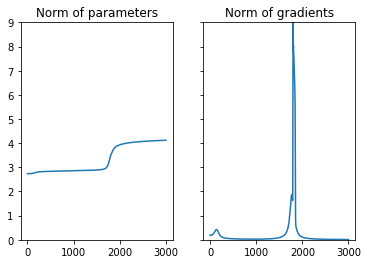

In [204]:
plot_trajectory(trajectory_2)

In [41]:
#But there is an explosion of the gradient 
#Sometimes is not even capable to overfit a single batch, the only way to avoid this problem 
#is using a balanced batch or weighting the loss 


In [26]:
new_dataset = My_Dataset(root ="bilanciato",transform = transforms)
new_train_loader = DataLoader(dataset = new_dataset, batch_size=15, shuffle=True )
data, targets = next(iter(new_train_loader))

In [27]:
model = BASE_CNN(1,15).to(device)
model.initialize_weight() 
optimizer = optim.SGD(model.parameters(),lr =0.01)
criterion = nn.CrossEntropyLoss() 

In [28]:
writer_3 = SummaryWriter(f'runs/MODEL_3')
trajectory_3 = {"parameters": [], "gradients": []}

In [29]:
overfit_single_batch(data,targets,model,criterion,writer_3,trajectory_3)

Epoch [1/3001]
0
Epoch [101/3001]
tensor(2.7079, grad_fn=<NllLossBackward0>)
Epoch [201/3001]
tensor(2.7079, grad_fn=<NllLossBackward0>)
Epoch [301/3001]
tensor(2.7078, grad_fn=<NllLossBackward0>)
Epoch [401/3001]
tensor(2.7078, grad_fn=<NllLossBackward0>)
Epoch [501/3001]
tensor(2.7076, grad_fn=<NllLossBackward0>)
Epoch [601/3001]
tensor(2.7073, grad_fn=<NllLossBackward0>)
Epoch [701/3001]
tensor(2.7067, grad_fn=<NllLossBackward0>)
Epoch [801/3001]
tensor(2.7050, grad_fn=<NllLossBackward0>)
Epoch [901/3001]
tensor(2.6936, grad_fn=<NllLossBackward0>)
Epoch [1001/3001]
tensor(0.3562, grad_fn=<NllLossBackward0>)
Epoch [1101/3001]
tensor(0.0056, grad_fn=<NllLossBackward0>)
Epoch [1201/3001]
tensor(0.0021, grad_fn=<NllLossBackward0>)
Epoch [1301/3001]
tensor(0.0012, grad_fn=<NllLossBackward0>)
Epoch [1401/3001]
tensor(0.0008, grad_fn=<NllLossBackward0>)
Epoch [1501/3001]
tensor(0.0006, grad_fn=<NllLossBackward0>)
Epoch [1601/3001]
tensor(0.0005, grad_fn=<NllLossBackward0>)
Epoch [1701/3001

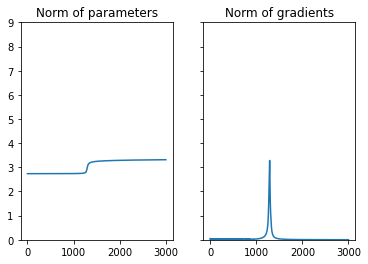

In [167]:
plot_trajectory(trajectory_3)

In [80]:
#I use this like a weight initializer and then I train the model on the whole data set 
#so a save the state dict of the model 

In [168]:
FIRST_PATH = "init_model.py"
torch.save({
            'parameters':model.state_dict()
        },FIRST_PATH)

In [169]:
#to train the model I use early stopping, which is not implemented in pytorch 
#so I implemented by myself 

In [30]:
def validation(model, val_loader, criterion): 
    losses = []
    num_correct = 0
    num_samples = 0
    with torch.no_grad(): 
        for _, (data,targets) in enumerate(val_loader): 
            data = data.to(device)
            targets = targets.to(device)
            scores = model(data) 
            loss = criterion(scores,targets)
            losses.append(loss.item())
            _, pred = scores.max(1)
            num_correct += (pred==targets).sum() 
            num_samples += pred.size(0) 
    
    mean_loss = np.mean(np.asarray(losses))
    accuracy = float(num_correct)/float(num_samples)*100
    return accuracy ,mean_loss
             

In [31]:
def early_stopping(PATH,first_epochs,model,train_loader,val_loader, criterion, optimizer,writer,max_epochs,patience=20): 
    model.train() 

    step = 0
    train_model(model, first_epochs, train_loader, criterion, optimizer, writer,step)
    model.eval()

    accuracy_new,loss = validation(model, val_loader, nn.CrossEntropyLoss())
    step+=first_epochs
    writer.add_scalar('Validation_accuracy',accuracy_new,step)
    writer.add_scalar('Validation_loss',loss,global_step=step)
    

   
    while(step<=max_epochs+1): #there is one more epoch to save the model
        
        
       
        torch.save({
            'parameters':model.state_dict()
        },PATH)
        
        accuracy_old = accuracy_new 
        count=0
        
        accuracy_new = 0
        
        while(accuracy_new<accuracy_old and count<patience): 
            count+=1
            
            model.train()
            train_model(model,1, train_loader, criterion, optimizer,writer,step)
            step+=1
            model.eval()
            accuracy_new, loss = validation(model, val_loader, criterion)
          
            writer.add_scalar('Validation_accuracy',accuracy_new,global_step=step)
            writer.add_scalar('Validation_loss',loss,global_step=step)
            
    
        if(count>=patience and accuracy_new<accuracy_old): 
            step = step -patience
            
            break 
        
            
    
    return step    
            

In [27]:
writer_4 = SummaryWriter(f'runs/MODEL_4')
#criterion = nn.CrossEntropyLoss() 

In [28]:
PATH = "model.py"

In [29]:
#The model was the last created so I don't need to load the dict 

In [32]:
ep =early_stopping(PATH,5,model,train_loader,val_loader, criterion, optimizer,writer_4,80,patience=15)

In [ ]:
#Training for 39 epochs is the best in this case, but instead of retraining the model I load the saved model that 
#has been trained for 39 epochs 


In [177]:
new_model = BASE_CNN(1,15).to(device)
check = torch.load(PATH)
new_model.load_state_dict(check['parameters'])


<All keys matched successfully>

In [178]:
_ = new_model.eval()
a, _=validation(new_model,val_loader,nn.CrossEntropyLoss())

In [179]:
a

35.11111111111111

In [180]:
test_data = My_Dataset(root="test",transform=transforms)
test_loader = DataLoader(dataset = test_data, batch_size=len(test_data), shuffle=False )

In [181]:
len(test_data)

2985

In [182]:
device="cpu"
new_model.to(device)

BASE_CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
  )
  (fcs): Sequential(
    (0): Linear(in_features=4608, out_features=15, bias=True)
  )
)

In [183]:
#test accuracy 
a,_ = validation(new_model,test_loader,nn.CrossEntropyLoss())

In [185]:
a 

29.279731993299833

In [186]:
test_data, test_targets = next(iter(test_loader))

In [187]:
with torch.no_grad():
    scores = new_model(test_data)

In [188]:
targets= test_targets.numpy()

In [189]:
_,predictions= scores.max(1)
predictions = predictions.numpy()

In [191]:
cm = confusion_matrix(targets,predictions)

In [192]:
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]

In [193]:
df_cm = pd.DataFrame(normalized_cm , index = [i for i in range(15)],
                     columns = [i for i in range(15)])

<AxesSubplot:>

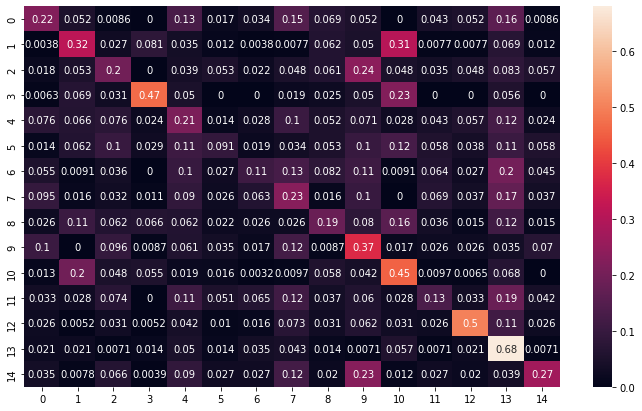

In [194]:
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)